# Flower Classification

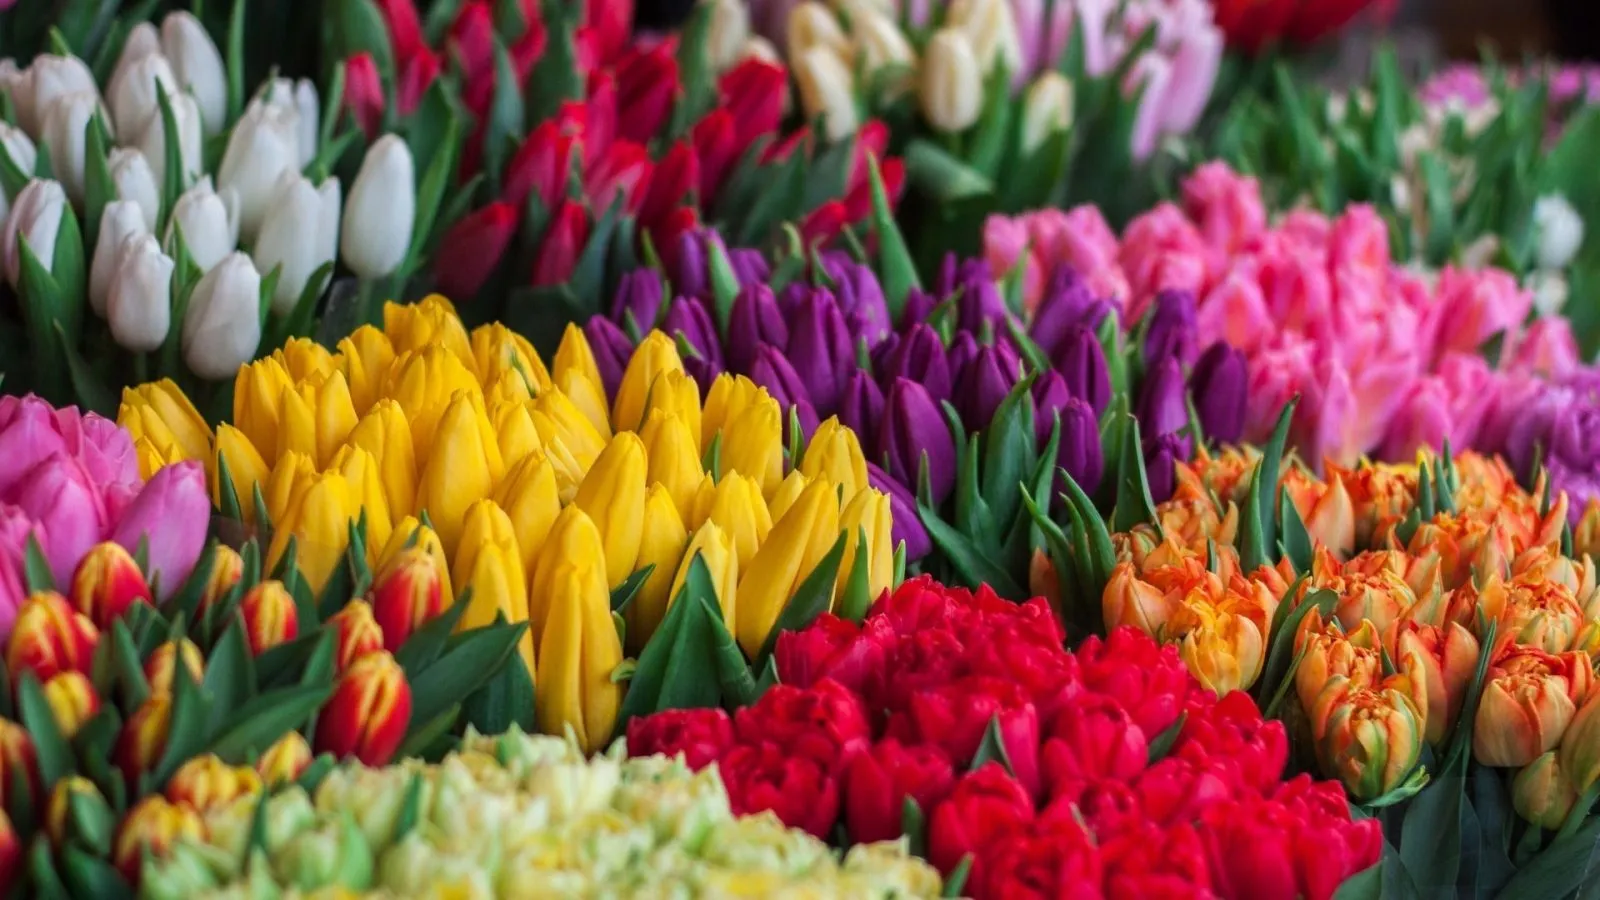

For this task you need to download the images of the 3 categories of flowers in 3 floders. Then use ImageDataGenerator to augment data. After this use the VGG16 for transfer learning and classification of the flowers. You need to compare it with other combination of CNN architectures mentioned in the task below. You also need to test your model with a photo that was is downloaded below.

# Use VGG16 to Extract features

## Compare optimizers:

SGD(lr=0.0001, momentum=0.9)
Adam (learning_rate = 0.0001)
rmsprop

loss='categorical_crossentropy'

## ImageDataGenerator
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

rescale -> convert the pixels in range [0,255] to range [0,1]

zoom -> [0.5, 1.5]

rotation -> 40

brightness -> (0.1, 0.9)

channel_shift -> 150.0

horizontal/vertical_flip -> True

width_shift_range=0.3, fill_mode='nearest'

## Compare it with Sequential model below

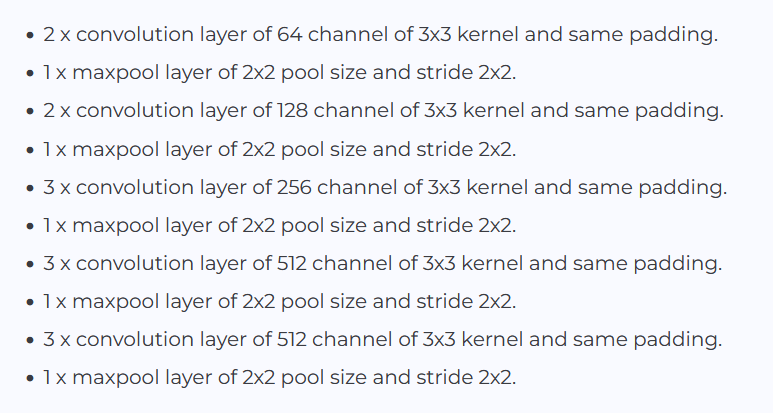

# Fully Connected Part of the Network


GlobalMaxPooling2D

Dropout(0.5)

Dense Softmax layer


## Visualize validation vs training

In [1]:
!gdown 1fAMA1xnDDTZO1Xc5s3kdfuTEgDVSn7qk
!gdown 1xe7o34YULxmZvr5QaMt9x0sqHJqE3-Tp

Downloading...
From (original): https://drive.google.com/uc?id=1fAMA1xnDDTZO1Xc5s3kdfuTEgDVSn7qk
From (redirected): https://drive.google.com/uc?id=1fAMA1xnDDTZO1Xc5s3kdfuTEgDVSn7qk&confirm=t&uuid=487e9b6b-61c4-4de8-b153-e6b18f465eae
To: /content/flowers.zip
100% 150M/150M [00:01<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xe7o34YULxmZvr5QaMt9x0sqHJqE3-Tp
To: /content/rose_test.jpeg
100% 270k/270k [00:00<00:00, 92.7MB/s]


In [2]:
flower_list = ['sunflower', 'tulip', 'rose']

# Modeling

In [3]:
import os
import shutil
from zipfile import ZipFile
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Crear directorio para las imágenes
data_dir = '/content/flower_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Descargar y descomprimir las imágenes
!gdown --id 1fAMA1xnDDTZO1Xc5s3kdfuTEgDVSn7qk
!gdown --id 1xe7o34YULxmZvr5QaMt9x0sqHJqE3-Tp

# Extraer archivos zip
with ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

flower_list = ['sunflower', 'tulip', 'rose']

for flower in flower_list:
    os.makedirs(os.path.join(data_dir, 'train', flower), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'valid', flower), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'test', flower), exist_ok=True)

    # Obtener lista de imágenes de la flor actual
    flower_images = os.listdir(os.path.join(data_dir, flower))

    # Dividir las imágenes en 80% entrenamiento, 10% validación y 10% prueba
    num_images = len(flower_images)
    num_train = int(0.8 * num_images)
    num_valid = int(0.1 * num_images)
    num_test = num_images - num_train - num_valid

    # Mover las imágenes a las carpetas correspondientes
    for i, image in enumerate(flower_images):
        src_path = os.path.join(data_dir, flower, image)
        if i < num_train:
            dest_path = os.path.join(data_dir, 'train', flower, image)
        elif i < num_train + num_valid:
            dest_path = os.path.join(data_dir, 'valid', flower, image)
        else:
            dest_path = os.path.join(data_dir, 'test', flower, image)
        shutil.move(src_path, dest_path)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir tamaño de lote y tamaño de imagen
batch_size = 32
img_size = (224, 224)

# Definir el generador de imágenes
datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=[0.5, 1.5],
    rotation_range=40,
    brightness_range=(0.1, 0.9),
    channel_shift_range=150.0,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.3,
    fill_mode='nearest'
)

# Crear generadores de datos de entrenamiento, validación y prueba
train_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'valid'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Cargar el modelo VGG16 sin la capa densa superior (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Congelar las capas convolucionales para evitar que se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas densas personalizadas para la clasificación de las flores
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(flower_list), activation='softmax')(x)

# Compilar el modelo
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Imprimir resumen del modelo
model_vgg16.summary()

from tensorflow.keras.optimizers import SGD

# Compilar el modelo
model_vgg16.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1fAMA1xnDDTZO1Xc5s3kdfuTEgDVSn7qk
From (redirected): https://drive.google.com/uc?id=1fAMA1xnDDTZO1Xc5s3kdfuTEgDVSn7qk&confirm=t&uuid=8aa1d039-267c-40e6-a31d-235f9783a0e3
To: /content/flowers.zip
100% 150M/150M [00:01<00:00, 132MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xe7o34YULxmZvr5QaMt9x0sqHJqE3-Tp
To: /content/rose_test.jpeg
100% 270k/270k [00:00<00:00, 

Epoch 1/10
62/62 [==============================] - 1232s 20s/step - loss: 1.1417 - accuracy: 0.3791 - val_loss: 1.0633 - val_accuracy: 0.4464
Epoch 2/10
62/62 [==============================] - 1226s 20s/step - loss: 1.0853 - accuracy: 0.4065 - val_loss: 1.0707 - val_accuracy: 0.3839
Epoch 3/10
62/62 [==============================] - 1205s 19s/step - loss: 1.0720 - accuracy: 0.4212 - val_loss: 1.0856 - val_accuracy: 0.3482
Epoch 4/10
62/62 [==============================] - 1202s 19s/step - loss: 1.0636 - accuracy: 0.4187 - val_loss: 1.0531 - val_accuracy: 0.4464
Epoch 5/10
62/62 [==============================] - 1221s 20s/step - loss: 1.0463 - accuracy: 0.4375 - val_loss: 1.0300 - val_accuracy: 0.4866
Epoch 6/10
62/62 [==============================] - 1221s 20s/step - loss: 1.0690 - accuracy: 0.4131 - val_loss: 1.0336 - val_accuracy: 0.5491
Epoch 7/10
62/62 [==============================] - 1224s 20s/step - loss: 1.0592 - accuracy: 0.4329 - val_loss: 1.0342 - val_accuracy: 0.4286

Este proceso proporciona un flujo completo para la construcción, entrenamiento y evaluación de un modelo de clasificación de imágenes utilizando transferencia de aprendizaje con la arquitectura VGG16.

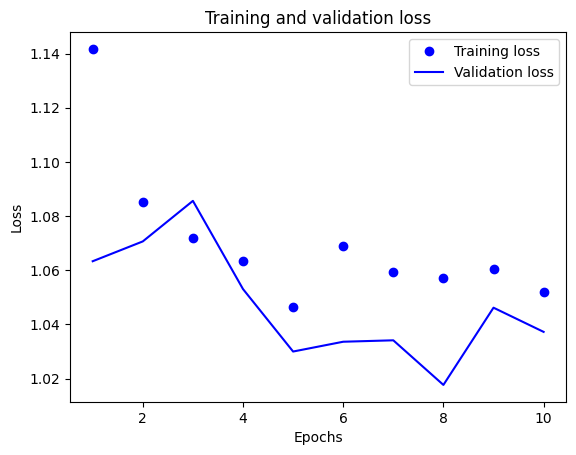

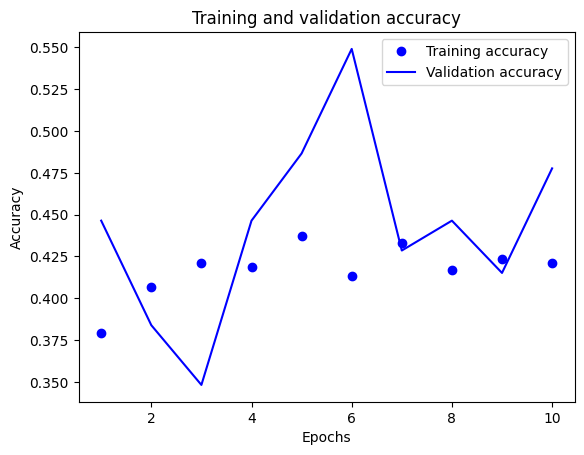

In [4]:
import matplotlib.pyplot as plt

# Obtener las curvas de pérdida y precisión del historial de entrenamiento
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
accuracy = history_vgg16.history['accuracy']
val_accuracy = history_vgg16.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Graficar las curvas de pérdida
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar las curvas de precisión
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 1s 748ms/step


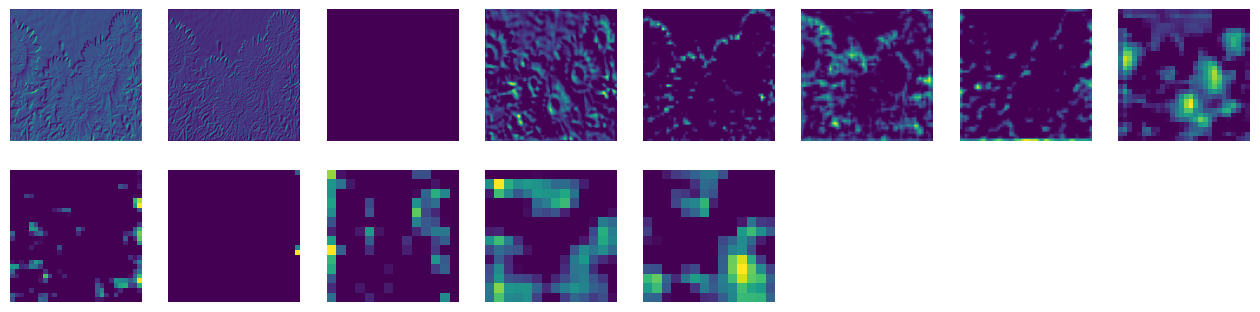

'\nEstos filtros representan las características aprendidas por el modelo en diferentes niveles de abstracción.\n'

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model

# Obtener la salida de las capas convolucionales intermedias
layer_outputs = [layer.output for layer in model_vgg16.layers if 'conv' in layer.name]
activation_model = Model(inputs=model_vgg16.input, outputs=layer_outputs)

# Seleccionar una imagen de prueba
img_path = '/content/flower_data/test/sunflower/1008566138_6927679c8a.jpg'

# Preprocesar la imagen
from tensorflow.keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Obtener las activaciones de las capas convolucionales
activations = activation_model.predict(img_tensor)

# Visualizar los filtros convolucionales
plt.figure(figsize=(16, 8))
for i, activation in enumerate(activations):
    plt.subplot(4, 8, i+1)
    plt.imshow(activation[0, :, :, 0], cmap='viridis')
    plt.axis('off')
plt.show()

"""
Estos filtros representan las características aprendidas por el modelo en diferentes niveles de abstracción.
"""

8/8 [==============================] - 162s 18s/step


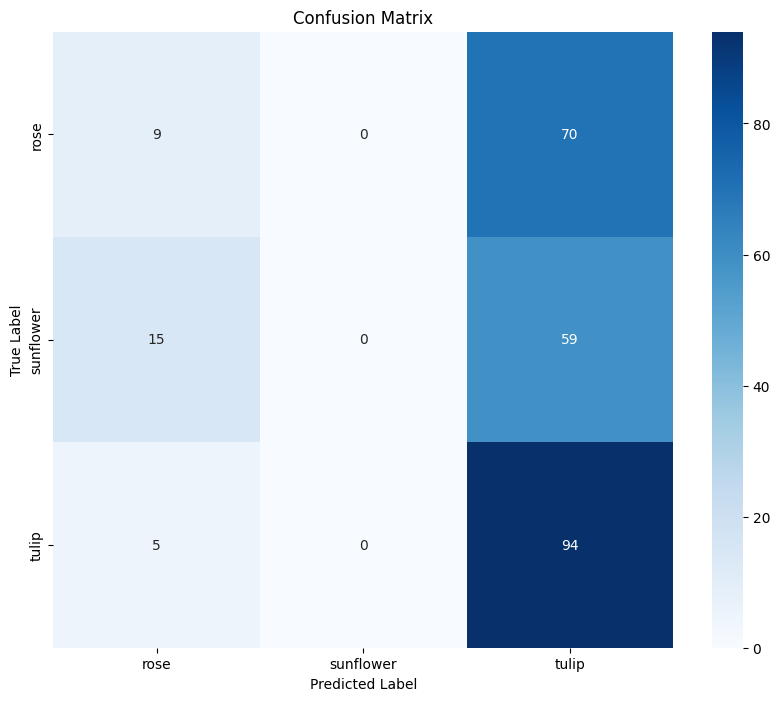

              precision    recall  f1-score   support

        rose       0.31      0.11      0.17        79
   sunflower       0.00      0.00      0.00        74
       tulip       0.42      0.95      0.58        99

    accuracy                           0.41       252
   macro avg       0.24      0.35      0.25       252
weighted avg       0.26      0.41      0.28       252



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model_vgg16.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
true_classes = test_generator.classes

# Obtener el nombre de las clases
class_labels = list(test_generator.class_indices.keys())

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(true_classes, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

""" el modelo tiene una exactitud del 41%, lo que significa que el 41% de las muestras en el conjunto de datos de prueba fueron clasificadas correctamente. """

Estos resultados muestran que el modelo tiene dificultades para distinguir entre las clases "rose" y "sunflower", ya que tienen una baja precisión y recall. La clase "tulipán" tiene un rendimiento mucho mejor, con una precisión y recall más altos.

8/8 [==============================] - 147s 17s/step


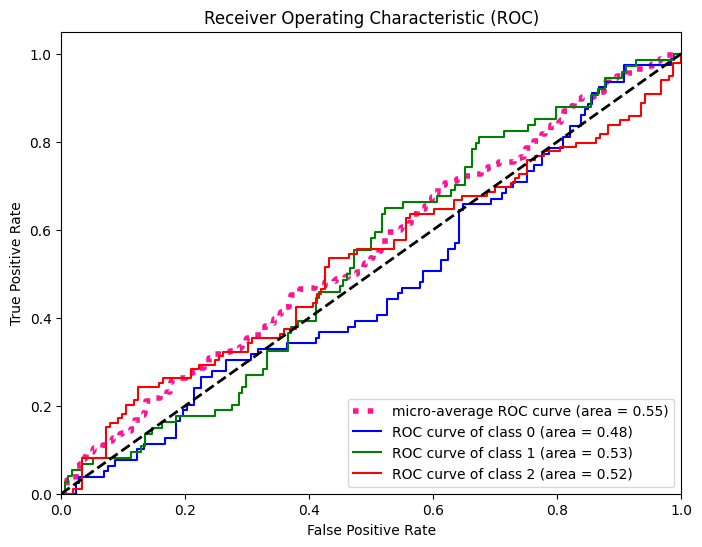

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

# Convertir las etiquetas en formato binario
y_test_binary = label_binarize(test_generator.classes, classes=[0, 1, 2])

# Calcular las probabilidades de predicción para cada clase
y_score = model_vgg16.predict(test_generator)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(flower_list)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular el micro-average ROC y AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotear la curva ROC para cada clase y el micro-average ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['b', 'g', 'r']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
"""Se calcula y traza la curva ROC para cada clase individualmente, así como el micro-average ROC que combina las tasas de verdaderos positivos y falsos positivos de todas las clases. Esto te permite evaluar el rendimiento del modelo tanto a nivel de clase como en general."""

Micro-average ROC curve (area = 0.55): La curva ROC combinada de todas las clases muestra un rendimiento moderado, con un AUC de 0.55. Esto indica que el modelo tiene cierta capacidad para distinguir entre las clases positivas y negativas en general.

ROC curve of Class 0 (area = 0.48): La curva ROC para la clase 0 muestra un rendimiento deficiente, con un AUC de 0.48. Esto sugiere que el modelo tiene dificultades para distinguir correctamente entre los verdaderos positivos y los falsos positivos para esta clase específica.

ROC curve of Class 1 (area = 0.53): La curva ROC para la clase 1 muestra un rendimiento ligeramente mejor que la clase 0, con un AUC de 0.53. Aunque todavía no es muy alto, indica que el modelo tiene una capacidad ligeramente mejor para clasificar esta clase en comparación con la clase 0.

ROC curve of Class 2 (area = 0.52): La curva ROC para la clase 2 muestra un rendimiento similar al de la clase 1, con un AUC de 0.52. Esto sugiere que el modelo tiene una capacidad moderada para clasificar esta clase en particular.

En resumen, el modelo muestra un rendimiento moderado en general, con algunas clases que se clasifican mejor que otras.